In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

sparkDF = spark.read.csv('data/data.csv', header=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/21 02:32:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## how many records

In [2]:
from pyspark.sql.functions import *

In [3]:
sparkDF.count()

541909

where does the most customers come from

In [4]:
sparkDF.groupBy("Country") \
        .agg(countDistinct('CustomerID').alias('country_count')) \
        .orderBy(desc('country_count'))\
        .show()

+---------------+-------------+
|        Country|country_count|
+---------------+-------------+
| United Kingdom|         3950|
|        Germany|           95|
|         France|           87|
|          Spain|           31|
|        Belgium|           25|
|    Switzerland|           21|
|       Portugal|           19|
|          Italy|           15|
|        Finland|           12|
|        Austria|           11|
|         Norway|           10|
|Channel Islands|            9|
|      Australia|            9|
|    Netherlands|            9|
|        Denmark|            9|
|         Cyprus|            8|
|          Japan|            8|
|         Sweden|            8|
|         Poland|            6|
|         Greece|            4|
+---------------+-------------+
only showing top 20 rows



most recent purchase

In [22]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
sparkDF.select(max(to_timestamp('InvoiceDate', "MM/d/yyyy H:mm")).alias("date")).cache().show()

23/01/21 04:28:20 WARN CacheManager: Asked to cache already cached data.
+-------------------+
|               date|
+-------------------+
|2011-12-09 12:50:00|
+-------------------+



In [ ]:
import pyspark.pandas as pd
sparkDF = sparkDF.withColumn("from_date", lit("12/1/10 08:26"))

# transform from_date to timestamp
sparkDF = sparkDF.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

sparkDF2 = sparkDF.withColumn('from_date',to_timestamp(col('from_date')))\
.withColumn('recency', col("InvoiceDate").cast("long") - col('from_date').cast("long"))

sparkDF2.show()

In [29]:
df_freq = sparkDF.groupBy("CustomerID").agg(count('InvoiceDate')).alias("Frequency")
df_freq.show(1)

+----------+------------------+
|CustomerID|count(InvoiceDate)|
+----------+------------------+
|     16250|                24|
+----------+------------------+
only showing top 1 row



In [34]:
sparkDF = sparkDF.join(df_freq, on="CustomerID", how='inner')
sparkDF.show(5)

+----------+---------+---------+--------------------+--------+--------------+---------+--------------+-------------+------------------+
|CustomerID|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|       Country|    from_date|count(InvoiceDate)|
+----------+---------+---------+--------------------+--------+--------------+---------+--------------+-------------+------------------+
|     17850|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|United Kingdom|12/1/10 08:26|               312|
|     17850|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|United Kingdom|12/1/10 08:26|               312|
|     17850|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|United Kingdom|12/1/10 08:26|               312|
|     17850|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|United Kingdom|12/1/10 08:26|               312|
|     17850|   536365|   84029E|RED WOOLLY HOTTI

In [36]:
m_val = sparkDF.withColumn('Total_spent', col('Quantity') * col('UnitPrice') )
m_val = m_val.groupBy("CustomerID").agg(sum('Total_spent')).alias("monetary_value")
m_val.show(5)

+----------+------------------+
|CustomerID|  sum(Total_spent)|
+----------+------------------+
|     16250|389.44000000000005|
|     15574| 702.2500000000002|
|     15555|4758.2000000000035|
|     15271|           2485.82|
|     17714|             153.0|
+----------+------------------+
only showing top 5 rows



In [37]:
finalDF = m_val.join(sparkDF, on="CustomerID", how="inner")
finalDF.show(3)

+----------+------------------+---------+---------+--------------------+--------+--------------+---------+--------------+-------------+------------------+
|CustomerID|  sum(Total_spent)|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|       Country|    from_date|count(InvoiceDate)|
+----------+------------------+---------+---------+--------------------+--------+--------------+---------+--------------+-------------+------------------+
|     16250|389.44000000000005|   536388|    21754|HOME BUILDING BLO...|       3|12/1/2010 9:59|     5.95|United Kingdom|12/1/10 08:26|                24|
|     16250|389.44000000000005|   536388|    21755|LOVE BUILDING BLO...|       3|12/1/2010 9:59|     5.95|United Kingdom|12/1/10 08:26|                24|
|     16250|389.44000000000005|   536388|    21523|DOORMAT FANCY FON...|       2|12/1/2010 9:59|     7.95|United Kingdom|12/1/10 08:26|                24|
+----------+------------------+---------+---------+-------------------

In [40]:
finalDF.select(['CustomerID', 'sum(Total_spent)', 'count(InvoiceDate)']).distinct().show(3)

+----------+------------------+------------------+
|CustomerID|  sum(Total_spent)|count(InvoiceDate)|
+----------+------------------+------------------+
|     16250|389.44000000000005|                24|
|     15574| 702.2500000000002|               168|
|     15555|4758.2000000000035|               925|
+----------+------------------+------------------+
only showing top 3 rows



In [50]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

assemble = VectorAssembler(inputCols=["sum(Total_spent)", "count(InvoiceDate)"], outputCol="features")
assemble_data = assemble.transform(finalDF)

scale = StandardScaler(inputCol="features", outputCol="Standardized")
data_scale = scale.fit(assemble_data)
data_scale_output = data_scale.transform(assemble_data)
data_scale_output.select(['CustomerID', 'sum(Total_spent)', 'count(InvoiceDate)', 'features']).distinct().show(truncate=False)

+----------+------------------+------------------+--------------------------+
|CustomerID|sum(Total_spent)  |count(InvoiceDate)|features                  |
+----------+------------------+------------------+--------------------------+
|16250     |389.44000000000005|24                |[389.44000000000005,24.0] |
|15574     |702.2500000000002 |168               |[702.2500000000002,168.0] |
|15555     |4758.2000000000035|925               |[4758.2000000000035,925.0]|
|15271     |2485.82           |275               |[2485.82,275.0]           |
|17714     |153.0             |10                |[153.0,10.0]              |
|17686     |5739.46           |286               |[5739.46,286.0]           |
|13865     |501.56000000000006|30                |[501.56000000000006,30.0] |
|14157     |400.4300000000001 |49                |[400.4300000000001,49.0]  |
|13610     |1115.4299999999996|228               |[1115.4299999999996,228.0]|
|17757     |5585.490000000003 |742               |[5585.49000000

In [51]:
data_scale_output.select("standardized").show(truncate=False)

+-------------------------------------------+
|standardized                               |
+-------------------------------------------+
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497628822223]|
|[0.012919022820330257,0.016306497

In [54]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import numpy as np

cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='Standardized', metricName='silhouette'
                               ,distanceMeasure='squaredEuclidean')

for i in range(2, 10):
    KMeans_algo = KMeans(featuresCol='Standardized', k=i)
    KMeans_fit = KMeans_algo.fit(data_scale_output)
    output = KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

23/01/21 15:15:10 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


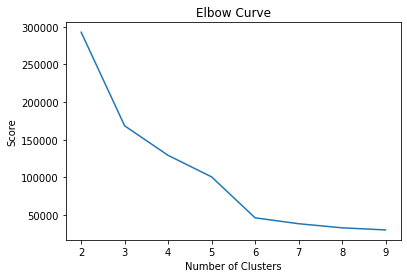

In [55]:
import pandas as pd
import pylab as pl

df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()